<a href="https://colab.research.google.com/github/ohjeonsuk/python-education/blob/main/L231018.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter09/cab_rides.csv
!wget -q https://raw.githubusercontent.com/rickiepark/handson-gb/main/Chapter09/weather.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier, XGBRFClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier
# Silence warnings
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('cab_rides.csv', nrows=10000)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   distance          10000 non-null  float64
 1   cab_type          10000 non-null  object 
 2   time_stamp        10000 non-null  int64  
 3   destination       10000 non-null  object 
 4   source            10000 non-null  object 
 5   price             9227 non-null   float64
 6   surge_multiplier  10000 non-null  float64
 7   id                10000 non-null  object 
 8   product_id        10000 non-null  object 
 9   name              10000 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 781.4+ KB


In [ ]:
df[df.isna().any(axis=1)]

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name
18,1.11,Uber,1543673584211,West End,North End,NaN,1.0,fa5fb705-03a0-4eb9-82d9-7fe80872f754,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
31,2.48,Uber,1543794776318,South Station,Beacon Hill,NaN,1.0,eee70d94-6706-4b95-a8ce-0e34f0fa8f37,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
40,2.94,Uber,1543523885298,Fenway,North Station,NaN,1.0,7f47ff53-7cf2-4a6a-8049-83c90e042593,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
60,1.16,Uber,1544731816318,West End,North End,NaN,1.0,43abdbe4-ab9e-4f39-afdc-31cfa375dc25,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
69,2.67,Uber,1543583283653,Beacon Hill,North End,NaN,1.0,80db1c49-9d51-4575-a4f4-1ec23b4d3e31,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
...,...,...,...,...,...,...,...,...,...,...
9949,1.08,Uber,1543272429665,North End,North Station,NaN,1.0,74fffcba-da67-42d1-b585-13d546a125be,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
9953,2.46,Uber,1545045010035,Beacon Hill,Fenway,NaN,1.0,18c2e91d-d594-4a22-9be7-0a5829efa4bf,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
9965,2.58,Uber,1544815809335,Beacon Hill,South Station,NaN,1.0,77adadfb-4ac7-4cdf-aeab-6c4cfe8f7b26,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi
9985,1.89,Uber,1544695512211,Beacon Hill,North End,NaN,1.0,f2dfa974-f9d1-4e90-a0e6-77f7eea16956,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi


In [ ]:
df.dropna(inplace=True)

In [ ]:
df['date'] = pd.to_datetime(df['time_stamp'])
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,1970-01-01 00:25:44.952607890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,1970-01-01 00:25:43.284023677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,1970-01-01 00:25:43.366822198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,1970-01-01 00:25:43.553582749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,1970-01-01 00:25:43.463360223


In [ ]:
pd.to_datetime(df['time_stamp'], unit='ms')

0      2018-12-16 09:30:07.890
1      2018-11-27 02:00:23.677
2      2018-11-28 01:00:22.198
3      2018-11-30 04:53:02.749
4      2018-11-29 03:49:20.223
                 ...          
9995   2018-11-29 15:12:59.037
9996   2018-12-03 01:27:57.997
9997   2018-11-28 12:11:23.241
9998   2018-12-15 18:00:13.623
9999   2018-12-03 04:53:01.166
Name: time_stamp, Length: 9227, dtype: datetime64[ns]

In [ ]:
df['date']=pd.to_datetime(df['time_stamp']*(10**6))

In [ ]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9227 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   distance          9227 non-null   float64       
 1   cab_type          9227 non-null   object        
 2   time_stamp        9227 non-null   int64         
 3   destination       9227 non-null   object        
 4   source            9227 non-null   object        
 5   price             9227 non-null   float64       
 6   surge_multiplier  9227 non-null   float64       
 7   id                9227 non-null   object        
 8   product_id        9227 non-null   object        
 9   name              9227 non-null   object        
 10  date              9227 non-null   datetime64[ns]
 11  month             9227 non-null   int64         
 12  hour              9227 non-null   int64         
 13  dayofweek         9227 non-null   int64         
 14  weekend           9227 n

In [ ]:
df['month'] = df['date'].dt.month
df['hour'] = df['date'].dt.hour
df['dayofweek'] = df['date'].dt.dayofweek

In [ ]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890,12,9,6
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677,11,2,1
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198,11,1,2
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749,11,4,4
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223,11,3,3


In [ ]:
def weekend(row):
    if row['dayofweek'] in [5, 6]:
        return 1
    else:
        return 0

df['weekend']=df.apply(weekend, axis=1)

In [ ]:
df.head()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek,weekend
0,0.44,Lyft,1544952607890,North Station,Haymarket Square,5.0,1.0,424553bb-7174-41ea-aeb4-fe06d4f4b9d7,lyft_line,Shared,2018-12-16 09:30:07.890,12,9,6,1
1,0.44,Lyft,1543284023677,North Station,Haymarket Square,11.0,1.0,4bd23055-6827-41c6-b23b-3c491f24e74d,lyft_premier,Lux,2018-11-27 02:00:23.677,11,2,1,0
2,0.44,Lyft,1543366822198,North Station,Haymarket Square,7.0,1.0,981a3613-77af-4620-a42a-0c0866077d1e,lyft,Lyft,2018-11-28 01:00:22.198,11,1,2,0
3,0.44,Lyft,1543553582749,North Station,Haymarket Square,26.0,1.0,c2d88af2-d278-4bfd-a8d0-29ca77cc5512,lyft_luxsuv,Lux Black XL,2018-11-30 04:53:02.749,11,4,4,0
4,0.44,Lyft,1543463360223,North Station,Haymarket Square,9.0,1.0,e0126e1f-8ca9-4f2e-82b3-50505a09db9a,lyft_plus,Lyft XL,2018-11-29 03:49:20.223,11,3,3,0


In [ ]:
def rush_hour(row):
    if (row['hour'] in [6, 7, 8, 9, 15, 16, 17, 18]) & (row['weekend']==0):
        return 1
    else:
        return 0
df['rush_hour'] = df.apply(rush_hour, axis=1)

In [ ]:
df.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek,weekend,rush_hour
9995,3.05,Uber,1543504379037,Fenway,North Station,11.5,1.0,934d2fbe-f978-4495-9786-da7b4dd21107,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-29 15:12:59.037,11,15,3,0,1
9996,3.05,Uber,1543800477997,Fenway,North Station,26.0,1.0,af8fd57c-fe7c-4584-bd1f-beef1a53ad42,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03 01:27:57.997,12,1,0,0,0
9997,3.05,Uber,1543407083241,Fenway,North Station,19.5,1.0,b3c5db97-554b-47bf-908b-3ac880e86103,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-28 12:11:23.241,11,12,2,0,0
9998,3.05,Uber,1544896813623,Fenway,North Station,36.5,1.0,fcb35184-9047-43f7-8909-f62a7b17b6cf,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-15 18:00:13.623,12,18,5,1,0
9999,2.03,Lyft,1543812781166,Theatre District,Northeastern University,7.0,1.0,7f0e8caf-e057-41eb-bdef-27eb14c88122,lyft_line,Shared,2018-12-03 04:53:01.166,12,4,0,0,0


빈도 특성

In [ ]:
df.cab_type.value_counts()

Uber    4654
Lyft    4573
Name: cab_type, dtype: int64

In [ ]:
df['cab_freq']=df.groupby('cab_type')['cab_type'].transform('count')

In [ ]:
df.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek,weekend,rush_hour,cab_freq
9995,3.05,Uber,1543504379037,Fenway,North Station,11.5,1.0,934d2fbe-f978-4495-9786-da7b4dd21107,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-29 15:12:59.037,11,15,3,0,1,4654
9996,3.05,Uber,1543800477997,Fenway,North Station,26.0,1.0,af8fd57c-fe7c-4584-bd1f-beef1a53ad42,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03 01:27:57.997,12,1,0,0,0,4654
9997,3.05,Uber,1543407083241,Fenway,North Station,19.5,1.0,b3c5db97-554b-47bf-908b-3ac880e86103,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-28 12:11:23.241,11,12,2,0,0,4654
9998,3.05,Uber,1544896813623,Fenway,North Station,36.5,1.0,fcb35184-9047-43f7-8909-f62a7b17b6cf,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-15 18:00:13.623,12,18,5,1,0,4654
9999,2.03,Lyft,1543812781166,Theatre District,Northeastern University,7.0,1.0,7f0e8caf-e057-41eb-bdef-27eb14c88122,lyft_line,Shared,2018-12-03 04:53:01.166,12,4,0,0,0,4573


In [ ]:
df['cab_freq'] = df['cab_freq']/len(df)

In [ ]:
df.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek,weekend,rush_hour,cab_freq
9995,3.05,Uber,1543504379037,Fenway,North Station,11.5,1.0,934d2fbe-f978-4495-9786-da7b4dd21107,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-29 15:12:59.037,11,15,3,0,1,0.504389
9996,3.05,Uber,1543800477997,Fenway,North Station,26.0,1.0,af8fd57c-fe7c-4584-bd1f-beef1a53ad42,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03 01:27:57.997,12,1,0,0,0,0.504389
9997,3.05,Uber,1543407083241,Fenway,North Station,19.5,1.0,b3c5db97-554b-47bf-908b-3ac880e86103,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-28 12:11:23.241,11,12,2,0,0,0.504389
9998,3.05,Uber,1544896813623,Fenway,North Station,36.5,1.0,fcb35184-9047-43f7-8909-f62a7b17b6cf,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-15 18:00:13.623,12,18,5,1,0,0.504389
9999,2.03,Lyft,1543812781166,Theatre District,Northeastern University,7.0,1.0,7f0e8caf-e057-41eb-bdef-27eb14c88122,lyft_line,Shared,2018-12-03 04:53:01.166,12,4,0,0,0,0.495611


캐글 팁 - 평균 인코딩

평균 인코딩 : 범주형 특성을 타깃 값의 평균을 기반으로 수치 특성으로 변환

오랜지 색 10

7개의 타깃 1

3개의 타깃 0

평균 인코딩 값 = 0.7

In [ ]:
!pip install category_encoders

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.8/81.8 kB 2.7 MB/s eta 0:00:00


In [ ]:
from category_encoders.target_encoder import TargetEncoder

In [ ]:
encoder = TargetEncoder()
df['cab_type_mean']=encoder.fit_transform(df['cab_type'], df['price'])

In [ ]:
df.tail()

,distance,cab_type,time_stamp,destination,source,price,surge_multiplier,id,product_id,name,date,month,hour,dayofweek,weekend,rush_hour,cab_freq,cab_type_mean
9995,3.05,Uber,1543504379037,Fenway,North Station,11.5,1.0,934d2fbe-f978-4495-9786-da7b4dd21107,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,2018-11-29 15:12:59.037,11,15,3,0,1,0.504389,15.743446
9996,3.05,Uber,1543800477997,Fenway,North Station,26.0,1.0,af8fd57c-fe7c-4584-bd1f-beef1a53ad42,6c84fd89-3f11-4782-9b50-97c468b19529,Black,2018-12-03 01:27:57.997,12,1,0,0,0,0.504389,15.743446
9997,3.05,Uber,1543407083241,Fenway,North Station,19.5,1.0,b3c5db97-554b-47bf-908b-3ac880e86103,6f72dfc5-27f1-42e8-84db-ccc7a75f6969,UberXL,2018-11-28 12:11:23.241,11,12,2,0,0,0.504389,15.743446
9998,3.05,Uber,1544896813623,Fenway,North Station,36.5,1.0,fcb35184-9047-43f7-8909-f62a7b17b6cf,6d318bcc-22a3-4af6-bddd-b409bfce1546,Black SUV,2018-12-15 18:00:13.623,12,18,5,1,0,0.504389,15.743446
9999,2.03,Lyft,1543812781166,Theatre District,Northeastern University,7.0,1.0,7f0e8caf-e057-41eb-bdef-27eb14c88122,lyft_line,Shared,2018-12-03 04:53:01.166,12,4,0,0,0,0.495611,16.916357


#앙상블 만들기

모델들의 상관관계를 사용하자

여러모델로 앙상블 모델을 만들때는 상관관계가 낮은 모델들을 사용하자

모델들의 상관관계는 각 모델의 예측값의 상관관계를 판단

In [ ]:
from sklearn.datasets import load_breast_cancer

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
X.shape, y.shape

((569, 30), (569,))

In [ ]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=156)

In [ ]:
def classification_model(model):
    scores = cross_val_score(model, X, y, cv=kfold)
    return scores.mean()

In [ ]:
classification_model(XGBClassifier())

0.95960254618848

In [ ]:
classification_model(XGBClassifier(booster='gblinear'))

0.9700978108989288

In [ ]:
classification_model(XGBClassifier(booster='dart', one_drop=True))

0.9613569321533924

---
---
---


dart 를 이용한 회귀

In [ ]:
from sklearn.datasets import load_diabetes

In [ ]:
X,y = load_diabetes(return_X_y=True)

In [ ]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=2)
def regression_model(model, X=X, y=y):
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', cv=kfold)
    rmse = (-scores)**0.5
    return rmse.mean()

In [ ]:
from xgboost import XGBRegressor
regression_model(XGBRegressor(booster='dart', rate_drop=0.5))

64.6822703579804

---
---
---

In [ ]:
X, y = load_breast_cancer(return_X_y=True)

In [ ]:
X.shape, y.shape

((569, 30), (569,))

In [ ]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=156)

In [ ]:
classification_model(RandomForestClassifier(random_state=2))

0.9613258810743673

In [ ]:
classification_model(LogisticRegression(max_iter=10000))

0.9508306163639186

In [ ]:
classification_model(XGBClassifier(n_estimators=500, max_depth=2, learning_rate=0.1))

0.9789318428815401

In [ ]:
def y_preds(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    print(score)
    return y_pred

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
y_pred_gbtree = y_preds(XGBClassifier())

0.9440559440559441


In [ ]:
y_pred_dart = y_preds(XGBClassifier(booster='dart', one_drop=True))

0.958041958041958


In [ ]:
y_pred_gblinear = y_preds(XGBClassifier(booster='gblinear'))

0.958041958041958


In [ ]:
y_pred_forest = y_preds(RandomForestClassifier(random_state=2))

0.9370629370629371


In [ ]:
y_pred_logistic = y_preds(LogisticRegression(max_iter=10000))

0.9370629370629371


In [ ]:
y_pred_xgb = y_preds(XGBClassifier(max_depth=2, n_estimators=500, learning_rate=0.1))

0.965034965034965


In [ ]:
df_pred = pd.DataFrame(data=np.c_[y_pred_gbtree, y_pred_dart, y_pred_gblinear,
                                  y_pred_forest, y_pred_logistic, y_pred_xgb],
                       columns=['gbtree', 'dart', 'gblinear', 'forest', 'logistic', 'xgb'])

In [ ]:
df_pred.head()

,gbtree,dart,gblinear,forest,logistic,xgb
0,1,1,1,1,1,1
1,0,0,1,1,1,1
2,1,1,1,1,1,1
3,0,0,0,0,0,0
4,1,1,1,0,0,1


In [ ]:
df_pred.corr()

,gbtree,dart,gblinear,forest,logistic,xgb
gbtree,1.000000,0.970994,0.941988,0.898850,0.927777,0.927384
dart,0.970994,1.000000,0.941988,0.898850,0.927777,0.956473
gblinear,0.941988,0.941988,1.000000,0.956710,0.927777,0.956473
forest,0.898850,0.898850,0.956710,1.000000,0.943308,0.942396
logistic,0.927777,0.927777,0.927777,0.943308,1.000000,0.941715
xgb,0.927384,0.956473,0.956473,0.942396,0.941715,1.000000


VotingClassifier

In [ ]:
estimators = []
logistic_model = LogisticRegression(max_iter=10000)
estimators.append(('logistic', logistic_model))
xgb_model = XGBClassifier(max_depth=2, n_estimators=500, learning_rate=0.1)
estimators.append(('xgb', xgb_model))
rf_model = RandomForestClassifier(random_state=2)
estimators.append(('rf', rf_model))

In [ ]:
estimators

[('logistic', LogisticRegression(max_iter=10000)),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=0.1, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=2, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=500, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)),
 ('rf', RandomForestClassifier(random_state=2))]

In [ ]:
ensemble = VotingClassifier(estimators)

In [ ]:
scores=cross_val_score(ensemble, X, y, cv=kfold)

In [ ]:
scores.mean()

0.9595714951094549

StackingClassifier

In [ ]:
base_models = []
base_models.append(('lr', LogisticRegression()))
base_models.append(('xgb', XGBClassifier()))
base_models.append(('rf', RandomForestClassifier(random_state=2)))

In [ ]:
base_models

[('lr', LogisticRegression()),
 ('xgb',
  XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=None,
                colsample_bytree=None, device=None, early_stopping_rounds=None,
                enable_categorical=False, eval_metric=None, feature_types=None,
                gamma=None, grow_policy=None, importance_type=None,
                interaction_constraints=None, learning_rate=None, max_bin=None,
                max_cat_threshold=None, max_cat_to_onehot=None,
                max_delta_step=None, max_depth=None, max_leaves=None,
                min_child_weight=None, missing=nan, monotone_constraints=None,
                multi_strategy=None, n_estimators=None, n_jobs=None,
                num_parallel_tree=None, random_state=None, ...)),
 ('rf', RandomForestClassifier(random_state=2))]

In [ ]:
meta_model = LogisticRegression()

In [ ]:
clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)
scores = cross_val_score(clf, X, y, cv=kfold)
scores.mean()

0.9578481602235677

importance_ 그리기

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2)

In [ ]:
X.shape, y.shape

((569, 30), (569,))

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((426, 30), (426,), (143, 30), (143,))

In [ ]:
xgb_c = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_c.fit(X_train, y_train, eval_set=evals, eval_metric='logloss', early_stopping_rounds=100,
          verbose=True)
preds = xgb_c.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score
def get_clf_eval(y_test, pred=None, pred_probas=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #if pred_probas is not None:
    if pred_probas:
        auc_score = roc_auc_score(y_test, pred_probas)
        print(confusion)
        print(f'정확도 :{accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, f1_score: {f1:.4f}, AUC : {auc_score:.4f}')
        return
    print(confusion)
    print(f'정확도 :{accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, f1_score: {f1:.4f}')

In [ ]:
get_clf_eval(y_test, preds)

[[54  2]
 [ 4 83]]
정확도 :0.9580, 정밀도 : 0.9765, 재현율 : 0.9540, f1_score: 0.9651


In [ ]:
from xgboost import plot_importance

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

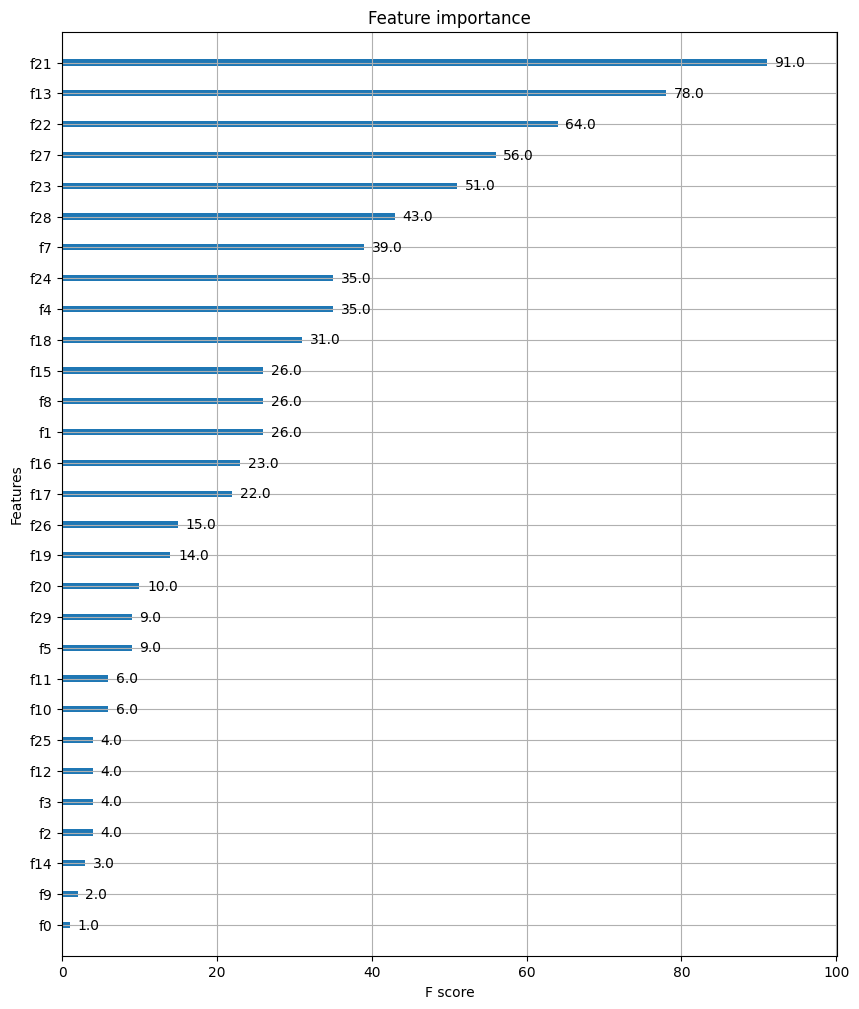

In [ ]:
fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_c, ax=ax)

#KNN (K-Nearest Neighbor)

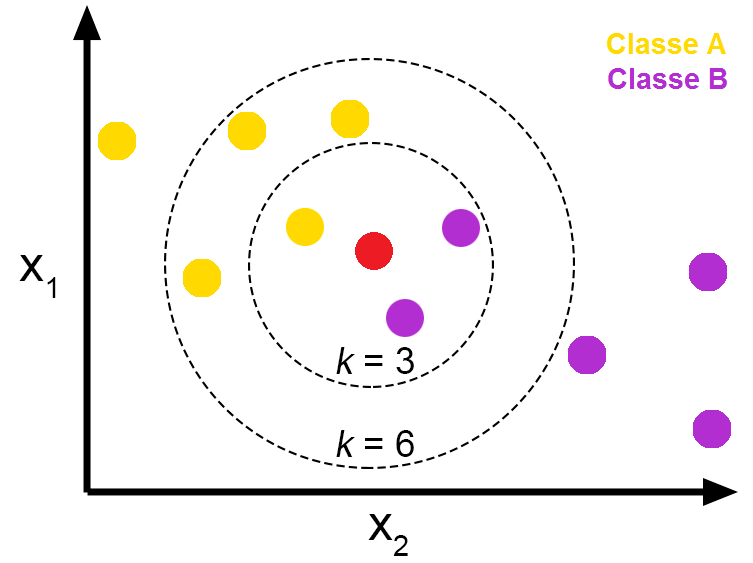

문제 : 새로운 데이터로 빨간 점이 주어졌을 때 Class A 와 Class B 중 어디로 분류 할 것인가?


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris = load_iris()

In [ ]:
X = iris.data
y = iris.target

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [ ]:
pd.Series(y_test).value_counts()

2    12
0     9
1     9
dtype: int64

In [ ]:
pd.Series(y_train).value_counts()

0    41
1    41
2    38
dtype: int64